## Reference:
* https://becominghuman.ai/time-series-and-how-to-detect-anomalies-in-them-part-i-7f9f6c2ad32e 
* https://becominghuman.ai/time-series-and-how-to-detect-anomalies-in-them-part-ii-bde9e69d0aaf 
* https://becominghuman.ai/time-series-and-how-to-detect-anomalies-in-them-part-iii-f72e800e15e2

In [1]:
from pathlib import Path # convenient way to deal w/ paths
import plotly.graph_objects as go # creates plots
import numpy as np # standard for data processing
import pandas as pd # standard for data processing
import json # we have anomalies' timestamps in json format

In [2]:
# path specification
# Path to the whole data from NAB git repository
nab = Path.cwd()/'NAB'

# This folder contains all files w/ metrics
data_path = nab/'data'

# There is also separate json file 
# w/ timestamps of anomalies in files w/ metrics
labels_filepath = nab/'labels/combined_labels.json'

# Path from data folder to the training file
training_filename = 'realAWSCloudwatch/rds_cpu_utilization_cc0c53.csv'

# Path from data folder to the validation file
valid_filename = 'realAWSCloudwatch/rds_cpu_utilization_e47b3b.csv'

In [3]:
# labels loading
with open(labels_filepath, 'r') as f:
    anomalies_timestamps = json.load(f)

In [4]:
# read data
train = pd.read_csv(data_path/training_filename)
valid = pd.read_csv(data_path/valid_filename)
train.head()

,timestamp,value
0,2014-02-14 14:30:00,6.456
1,2014-02-14 14:35:00,5.816
2,2014-02-14 14:40:00,6.268
3,2014-02-14 14:45:00,5.816
4,2014-02-14 14:50:00,5.862


In [5]:
# data standardization
from sklearn.preprocessing import StandardScaler

# Let's make it function for further usage
def parse_and_standardize(df: pd.DataFrame, scaler: StandardScaler = None):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['stand_value'] = df['value']
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(df['stand_value'].values.reshape(-1, 1))
    df['stand_value'] = scaler.transform(df['stand_value'].values.reshape(-1, 1))
    return scaler

data_scaler = parse_and_standardize(train)
parse_and_standardize(valid, data_scaler)

StandardScaler()

In [6]:
# anomalies extraction
train_anomalies = train[train['timestamp'].isin(anomalies_timestamps[training_filename])]
valid_anomalies = valid[valid['timestamp'].isin(anomalies_timestamps[valid_filename])]
print(f"\nThese are train_anomalies:\n{train_anomalies}")
print(f"\nThese are validation anomalies:\n{valid_anomalies}")


These are train_anomalies:
               timestamp    value  stand_value
3080 2014-02-25 07:15:00  25.1033     4.652449
3579 2014-02-27 00:50:00  19.1650     3.026441

These are validation anomalies:
               timestamp  value  stand_value
946  2014-04-13 06:52:00  76.23    18.651805
2585 2014-04-18 23:27:00  25.11     4.654283


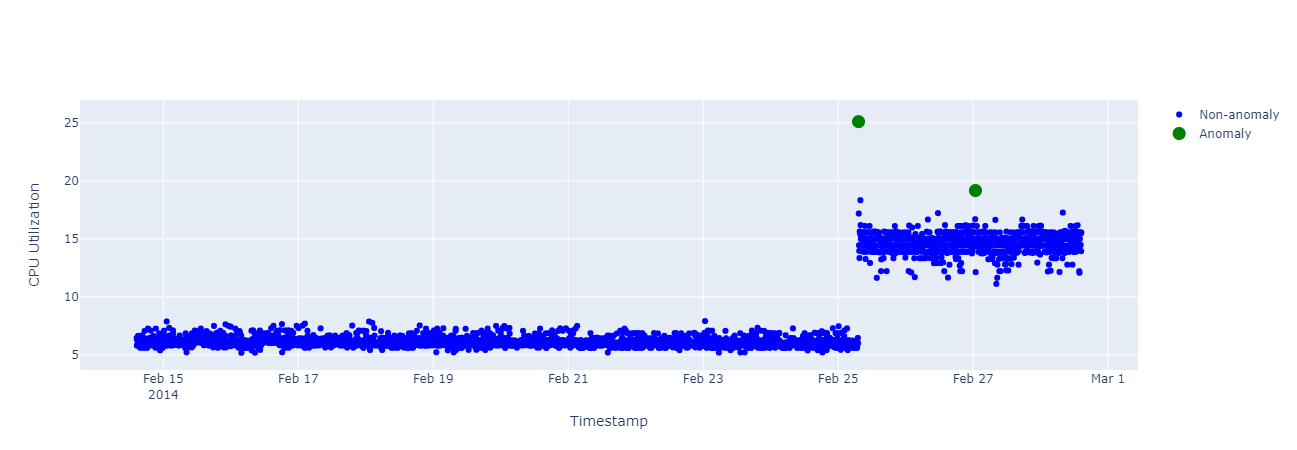

In [9]:
# plot training data
# Prepare layout w/ titles
layout = dict(xaxis=dict(title='Timestamp'), yaxis=dict(title='CPU Utilization')) 

# Create the figure for plotting the data
fig = go.Figure(layout=layout) 

# Add non-anomaly data to the figure
fig.add_trace(go.Scatter(x=train['timestamp'], y=train['value'], 
                         mode='markers', name='Non-anomaly',
                         marker=dict(color='blue')))

# Add anomaly data to the figure
fig.add_trace(go.Scatter(x=train_anomalies['timestamp'],
                         y=train_anomalies['value'], 
                         mode='markers', name='Anomaly',
                         marker=dict(color='green', size=13)))


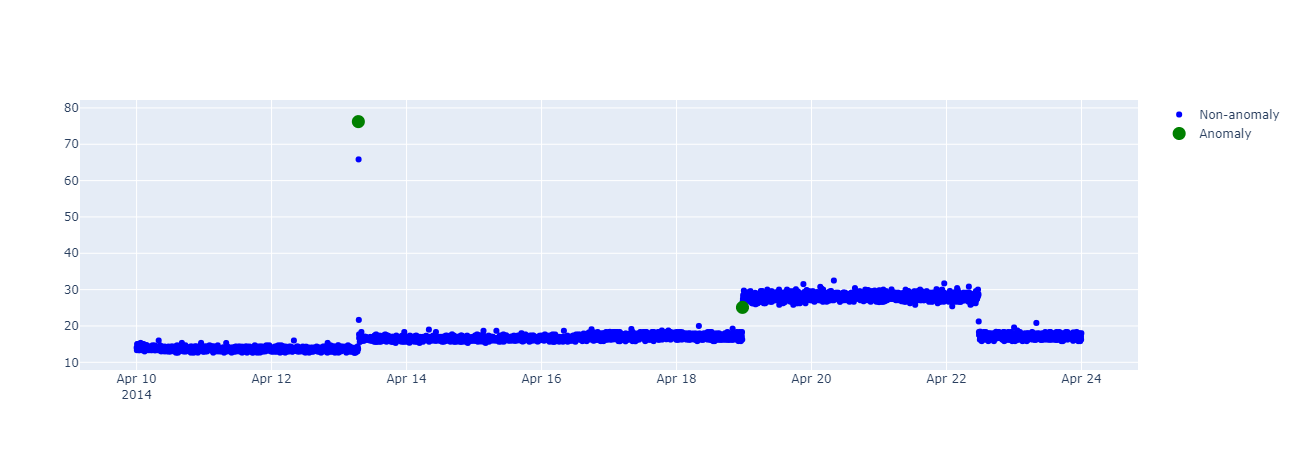

In [11]:
# plot validation data
fig = go.Figure()
fig.add_trace(go.Scatter(x=valid['timestamp'], y=valid['value'], 
                         mode='markers', name='Non-anomaly',
                         marker=dict(color='blue')))
fig.add_trace(go.Scatter(x=valid_anomalies['timestamp'],
                         y=valid_anomalies['value'], 
                         mode='markers', name='Anomaly',
                         marker=dict(color='green', size=13)))

In [14]:
import torch
from torch.utils.data import Dataset, DataLoader

In [ ]:
# losses_plot
layout = dict(xaxis=dict(title='Epoch'), yaxis=dict(title='Loss'))
fig = go.Figure(layout=layout)
fig.add_trace(go.Scatter(y=losses['train'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(y=losses['valid'], mode='lines', name='Valid Loss'))

In [ ]:
# lstm_dataset
class CPUDataset(Dataset):
    def __init__(self, data: pd.DataFrame, size: int):
        self.chunks = torch.FloatTensor(data['stand_value']).unfold(0, size, size)
        
    def __len__(self):
        return self.chunks.size(0)
    
    def __getitem(self, i):
        x = self.chunks[i]
        return x
    
train_ds = CPUDataset(train, 64)
valid_ds = CPUDataset(valid, 64)

In [ ]:
# LSTM definition
class LSTMModel(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, device):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(in_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size)
        self.device = device
        self.init_hidden()
        
    def forward(self, x):
        out, self.hidden_state = self.lstm(
            x.view(len(x), 1, -1), self.hidden_state
        )
        self.hidden_state = tuple(
            [h.detach() for h in self.hidden_state]
        )
        out = out.view(len(x), -1)
        out = self.linear(out)
        return out
    
    def init_hidden(self):
        self.hidden_state = (
            torch.zeros((1, 1, self.hidden_size)).to(self.device)
            torch.zeros((1, 1, self.hidden_size)).to(self.device)
        )

In [ ]:
# lstm training
def train_model(model: LSTMModel, dataloaders: dict, optimizer: opt.Optimizer,
                scheduler, criterion, device: torch.device, epochs: int):
    
    losses_data = {'train':[], 'valid':[]}
    model.to(device)
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch}/P{epochs-1}')
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.
            running_total = 0.
            
        # here changes start
        for idx, sequcence in enumerate(dataloaders[phase]):
            value = sequence
            value = value.to(device)
            
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                out = model(value.view(-1, 1))
                loss = criterion(out.view(-1), value.view(-1))
                
        # here changes end
        
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    scheduler.step()
                    
            running_loss += loss.item()*out.size(0)
            running_total += out.size(0)
            
        epoch_loss = running_loss / running_total
        print(f'{phase.capitalize()} Loss: {epoch_loss}')
        losses_data[phase].append(epoch_loss)
        
    return losses_data

In [ ]:
# lstm_parameters
epochs = 50
model = LSTMModel(1, 128, 1, device)
dataloaders = {
    'train': DataLoader(train_ds, batch_size=1),
    'valid': DataLoader(valid_ds, batch_size=1)
}
optim = opt.Adam(params=model.parameters(), lr=1e-3)
sched = opt.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, steps_per_epoch=len(dataloaders['train']), epochs=total_epoch_count
)
criterion = nn.MSELoss()
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
# lstm training run
losses = train_model(model, dataloaders, optim, sched, criterion, device, epochs)

In [ ]:
# lstm_sequence_extraction
train_values = train['stand_value'].values.astype(np.float32).flatten()
valid_values = valid['stand_value'].values.astype(np.float32).flatten()

In [ ]:
# LSTM predictions
# Switching model into evaluation mode
model.eval()

# calculation of the predictions for training data
with torch.no_grad():
    res_train = model(torch.tensor(train_values).to(device))
res_train = res_train.cpu()

# calculation of the predictions for validatoin data
with torch.no_grad():
    res_valid = model(torch.tensor(vlaid_values).to(device))
res_valid = res_valid.cpu()

In [ ]:
# lstm error calculation
def calculate_prediction_errors(target, predicted, criterion):
    reconstruction_errors = []
    for t, p in zip(target, predicted):
        reconstruction_errors = np.append(reconstruction_errors, 
                                         criterion(p, t).cpu().numpy().flatten()
                                         )
    return reconstruction_errors

train_pred_errors = calculate_prediction_errors(res_train.view(-1), torch.tensor(train_values).view(-1), criterion)
valid_pred_errors = calculate_prediction_errors(res_train.view(-1), torch.tensor(valid_values).view(-1), criterion)

In [ ]:
# static_threshold_formula
pred_error_threshold = np.mean(train_pred_errors) + 3*np.std(train_pred_errors)

In [ ]:
# dynamic threshold calculation

# we use Series from Pnadas to calculate windowed errors
train_pred_errors_windowed = pd.Series(train_pred_errors).rolling(window=window, min_periods=1)

# dynamic threshold for the training data
train_dynamic_threshold = train_pred_errors_windowed.mean() + std_coef * train_pred_errors_windowed.std()

valid_pred_errors_windowed = pd.Series(valid_pred_errors).rolling(window=window, min_periods=1)

# dynamic threshold for the validation data
valid_dynamic_threshold = valid_pred_errors_windowed.mean() + std_coef * valid_pred_errors_windowed.std()

In [ ]:
# metrics_calculation

# we are going to use this handy function for all metrics at oncee
# except confusion matrix
from sklearn.metrics import precision_recall_fscore_support

def calculate_metrics(
    ground_truth: pd.DataFrame, anomalies_idxs: list
    ):
    predictions = pd.DataFrame(
        index=range(len(ground_truth)),
        columns=['anomaly_predicted']
    )
    predictions['anomaly_predicted'] = 0
    predictions.iloc[anomalies_idxs] = 1
    
    # calculation of the confusion matrix can be done using pandas
    confusion_matrix = pd.crosstab(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'],
        margins=True
    )
    precision, recall, f1, _ = precision_recall_fscore_support(
        ground_truth.loc[:, 'anomaly_label'],
        predictions['anomaly_predicted'],
        beta=2,
        average='binary'
    )
    return confusion_matrix, precision, recall, f1

In [ ]:
def detect_anomalies(pred_error_threshold, df):
    # calculate errors for the given data
    test_reconstruction_errors = calculate_reconstruction_errors(df)
    # filter errors w/ the threshold
    predicted_anomalies = list(
        map(lambda v: 1 if v > pred_error_threshold else 0,
           test_reconstruction_errors)
    )
    df['anomaly_predicted'] = predicted_anomalies
    
    # Extract indexes of the filtered anomalies
    indexes = [i for i, x in enumerate(predicted_anomalies) if x == 1]
    return indexes

train_anomalies_idxs = detect_anomalies(
    pred_error_threshold, training_data_frame
)

valid_anomalies_idxs = detect_anomalies(
    pred_error_threshold, valid_data_frame
)

In [ ]:
# nns detect anomalies
from typing import Union

def detect_anomalies(
    result: torch.Tensor, dataset: CPUDataset,
    threshold: Union[float, pd.Series], n_factors: int = 0
):
    anomalies_idxs = []
    
    # we filter each item
    for i in range(len(dataset)):
        # the case of dynamic threshold
        if type(threshold) == pd.Series:
            is_anomaly = (criterion(result[i], dataset[i][1]) < threshold[i])
            
        # the case of static threshold
        else:
            is_anomaly = (criterion(result[i], dataset[i][1]) > threshold)
            
        if is_anomaly:
            # since the index of the prediction is next after
            # the index of the last factor, we should add the amount
            # of the factors
            anomalies_idxs.append(i + n_factors)
            
        return anomalies_idxs

In [ ]:
# LSTM DETECT anomalies run static
train_anomalies_idxs = detect_anomalies(res_train, torch.tensor(train_values), pred_error_threshold)
valid_anomalies_idxs = detect_anomalies(res_valid, torch.tensor(valid_values), pred_error_threshold)

In [ ]:
# LSTM detect anomalies run dynamic
train_anomalies_idxs = detect_anomalies(res_train, torch.tensor(train_values), train_dynamic_threshold)
valid_anomalies_idxs = detect_anomalies(res_valid, torch.tensor(valid_values), valid_dynamic_threshold)